In [1]:
import numpy as np
import pickle
import torch
import random
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import defaultdict

from IPython.display import clear_output

%matplotlib inline

In [2]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 9   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
                        # and 5 for ref bases STR info
REF_DOWNSAMPLE = 10 # choose this many ref reads randomly
MIN_REF = 5
ARTIFACT_POPAF_THRESHOLD = 5.9 # only let things absent from gnomAD be artifacts out of caution
GERMLINE_POPAF_THRESHOLD = 1 #also very cautious.  There are so many germline variants we can be wasteful!
TLOD_THRESHOLD = 6 # we are classified artifacts other than sequencing errors described by base qualities
NON_ARTIFACT_PER_ARTIFACT = 50 #ratio of non-artifact to artifact in unsupervised training data

In [3]:
#as a quick and robust estimate of the mean for the purpose of normalizing, we will take the median of medians of subsets
#for example, take the median of each group of 100 read sets, then take the median of those
NUM_SETS_PER_MEAN = 100

def find_normalization(data):
    medians = []
    spreads = []
    buffer = []
    for n, (ref_tensor, _, _) in enumerate(data):
        buffer.append(ref_tensor)
        
        if n > 0 and n % NUM_SETS_PER_MEAN == 0:
            medians.append(torch.quantile(torch.cat(buffer, dim=0), 0.5, dim=0))
            low_quantile = torch.quantile(torch.cat(buffer, dim=0), 0.02, dim=0)
            high_quantile = torch.quantile(torch.cat(buffer, dim=0), 0.98, dim=0)
            spreads.append(high_quantile - low_quantile)
            buffer.clear()
    mu = torch.median(torch.stack(medians), dim=0).values
    sigma = torch.median(torch.stack(spreads), dim=0).values
    
    return mu, sigma

def normalize(data, mu, sigma):
    return [((ref - mu) / sigma, (alt - mu) / sigma, is_artifact) for ref, alt, is_artifact in data]

In [4]:
    def num_repeats(ref_bases, k):
        N = len(ref_bases)
        n = int((N - 1)/2)   # note k > n will cause errors
        
        # extend a repeat forward, to front and then to back (both exclusive)
        # note that this only extends backward if they match the bases going forward
        # that is AAAAAGTGTCC (first G in the middle) will get extended forward through
        # both GTs but won't be extended back
        front = n + k
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1
        back = n - 1
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1    
        forward_repeats = (front - back - 1)/k
        
        # same idea but extending backwards first (now back is exclusive and front is inclusive)
        back = n - k
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1
        front = n + 1
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1  
        backward_repeats = (front - back - 1)/k
           
        return forward_repeats, backward_repeats

In [5]:
class SiteMetadata:
    def __init__(self, chromosome, position, ref, alt, popaf):
        self._locus = chromosome + ":" + str(position)
        self._ref = ref
        self._alt = alt
        self._popaf = popaf
        
    def locus(self):
        return self._locus
    
    def ref(self):
        return self._ref
    
    def alt(self):
        return self._alt
    
    def popaf(self):
        return self._popaf
    
class Mutect2Data:
    def __init__(self, tlod, tumor_dp, filters):
        self._tlod = tlod
        self._tumor_dp = tumor_dp
        self._filters = filters
        
    def tlod(self):
        return self._tlod
    
    def tumor_depth(self):
        return self._tumor_dp
    
    def filters(self):
        return self._filters
    
class VariantInfoFeatures:
    #hec is abbreviation for haplotype equivalence counts
    def __init__(self, hec, haplotype_complexity, haplotype_dominance, ref_bases):
        # take integer haplotype equivalence counts (already in order from greatest to least from Mutect)
        # and calculate the fractional share of the 2nd and 3rd, or 0 if none exist
        total = 0
        for n in hec:
            total += n
            
        self._info = [0.0 if len(hec) < 2 else hec[1]/total, 0.0 if len(hec) < 3 else hec[2]/total]
        
        # now append the haplotype complexity and haplotype dominance
        self._info.append(haplotype_complexity)
        self._info.append(haplotype_dominance)
        
        #TODO: process ref bases into a feature vector and append
        
        # ref bases is symmetrical and has 2n+1 bases, with the middle one being the site in question
        for k in range(1,6):
            fwd,back = num_repeats(ref_bases, k)
            self._info.append(max(fwd,back))
        
        self._info = torch.FloatTensor(self._info)
        
    def get_info_tensor(self):
        return self._info
    
    # count how many repeats of length k surround the middle base
    # example: num_repeats(GACTACTACTG,3) = 3
    def num_repeats(ref_bases, k):
        N = len(ref_bases)
        n = int((N - 1)/2)   # note k > n will cause errors
        
        # extend a repeat forward, to front and then to back (both exclusive)
        # note that this only extends backward if they match the bases going forward
        # that is AAAAAGTGTCC (first G in the middle) will get extended forward through
        # both GTs but won't be extended back
        front = n + k
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1
        back = n - 1
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1    
        forward_repeats = (front - back - 1)/k
        
        # same idea but extending backwards first (now back is exclusive and front is inclusive)
        back = n - k
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1
        front = n + 1
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1  
        backward_repeats = (front - back - 1)/k
           
        return max(forward_repeats, backward_repeats)

In [6]:
class Datum:
    def __init__(self, ref_tensor, alt_tensor, info_tensor, metadata, mutect2_data, artifact_label):
        self._ref_tensor = ref_tensor
        self._alt_tensor = alt_tensor
        self._info_tensor = info_tensor
        self._metadata = metadata
        self._mutect2_data = mutect2_data
        self._artifact_label = artifact_label
        
    def ref_tensor(self):
        return self._ref_tensor
    
    def alt_tensor(self):
        return self._alt_tensor
    
    def info_tensor(self):
        return self._info_tensor
    
    def metadata(self):
        return self._metadata
    
    def mutect2_data(self):
        return self._mutect2_data
    
    def artifact_label(self):
        return self._artifact_label

In [7]:
def index_if_exists(lis, element):
    return lis.index(element) if element in lis else None

def get_indices(lis, elements):
    return tuple(index_if_exists(lis, element) for element in elements)

ALLELE_SEPARATOR = '|'
# get the ref and alt tensors from the VariantsToTable raw output, convert to torch tensors, downsample ref if needed
def get_read_tensors(token, ref_downsample=None):
    tokens = token.split(ALLELE_SEPARATOR)
    ref, alt = tuple(np.fromstring(x, dtype=int, sep=',').reshape((-1, NUM_READ_FEATURES)) for x in tokens)
    ref, alt = torch.from_numpy(ref).float(), torch.from_numpy(alt).float()
    if (ref_downsample is not None and len(ref) > ref_downsample):
        ref = ref[torch.randperm(len(ref))[:ref_downsample]]
    return ref, alt

class TableReader:
    def __init__(self, header_tokens, tumor_sample, normal_sample=None):
        
        # site metadata
        self.chrom_idx, self.pos_idx, self.ref_allele_idx, self.alt_allele_idx, self.popaf_idx = \
            get_indices(header_tokens, ["CHROM", "POS", "REF", "ALT", "POPAF"])
        
        # Mutect2 data
        self.filter_idx, self.tlod_idx, self.tumor_dp_idx,  = \
            get_indices(header_tokens, ["FILTER", "TLOD", tumor_sample + ".DP"])
        
        # variant info features
        self.hec_idx, self.hapcomp_idx, self.hapdom_idx, self.ref_bases_idx = get_indices(header_tokens, ["HEC", "HAPCOMP", "HAPDOM", "REF_BASES"])
        
        self.status_idx = index_if_exists(header_tokens, "STATUS")
        self.tumor_idx = index_if_exists(header_tokens, tumor_sample + ".FRS")
        
        # optional normal data
        if normal_sample is not None:
            self.normal_idx, self.normal_dp_idx = get_indices(header_tokens, [normal_sample + ".FRS", normal_sample + ".DP"])
    
    def variant_info_features(self, tokens):
        haplotype_equivalence_counts = [int(n) for n in tokens[self.hec_idx].split(",")]
        haplotype_complexity = int(tokens[self.hapcomp_idx])
        haplotype_dominance = float(tokens[self.hapdom_idx])
        ref_bases = tokens[self.ref_bases_idx]
        return VariantInfoFeatures(haplotype_equivalence_counts, haplotype_complexity, haplotype_dominance, ref_bases)
        
    def site_metadata(self, tokens):
        chromosome = tokens[self.chrom_idx]
        position = int(tokens[self.pos_idx])
        ref = tokens[self.ref_allele_idx]
        alt = tokens[self.alt_allele_idx]
        popaf = float(tokens[self.popaf_idx]) 
        return SiteMetadata(chromosome, position, ref, alt, popaf)
    
    def mutect2_data(self, tokens):
        tlod = float(tokens[self.tlod_idx])
        tumor_dp = int(tokens[self.tumor_dp_idx])
        filters = set(tokens[self.filter_idx].split(","))
        return Mutect2Data(tlod, tumor_dp, filters)

    def status(self, tokens):
        return tokens[self.status_idx]
    
    def tumor_ref_and_alt(self, tokens, ref_downsample=None):
        return get_read_tensors(tokens[self.tumor_idx], ref_downsample)
    
    def normal_dp(self, tokens):
        return int(tokens[self.normal_dp_idx])
    
    def normal_ref_and_alt(self, tokens, ref_downsample=None):
        return get_read_tensors(tokens[self.normal_idx], ref_downsample)

In [8]:
# this takes a table from VariantsToTable and produces a list of either
# (ref tensor, alt tensor, and unsupervised label based on AF) if is_training = true
# (ref tensor, alt tensor, (position, filters, status)) if is_training = false
def make_tensors(raw_file, is_training, sample_name, normal_sample_name=None):
    data = []
            
    # simple online method for balanced data set where for each k-alt-read artifact there are 
    # NON_ARTIFACT_PER_ARTIFACT (downsampled) k-alt-read non-artifacts.  That is, alt count is not an informative feature.
    unmatched_artifact_counts = []
        
    with open(raw_file) as fp: 
        reader = TableReader(fp.readline().split(), sample_name, normal_sample_name)
        
        for n, line in enumerate(fp):
            if n % 100000 == 0:
                print("Processing line " + str(n))
                
            tokens = line.split()
            metadata = reader.site_metadata(tokens)
            m2_data = reader.mutect2_data(tokens)

            # Contamination and weak evidence / low log odds have low AFs but are not artifacts.  We exclude them
            # from training.  As for testing, M3 will continue to rely on them 
            if "contamination" in m2_data.filters() or "weak_evidence" in m2_data.filters() or m2_data.tlod() < TLOD_THRESHOLD:
                continue
                
            # for testing, M3 relies on the existing germline filter.  For training, we keep germline variants
            # and downsample to simulate true non-artifacts with varying allele fraction
            if "germline" in m2_data.filters() and not is_training:
                continue

            # in training, we want low popaf for true artifacts, high AF for true variants
            # in order to have more confident weak labels.  In between, discard.
            if  is_training and (GERMLINE_POPAF_THRESHOLD < metadata.popaf() < ARTIFACT_POPAF_THRESHOLD):
                continue

            ref_tensor, alt_tensor = reader.tumor_ref_and_alt(tokens, REF_DOWNSAMPLE)
            alt_count = len(alt_tensor)
            if alt_count == 0 or len(ref_tensor) < MIN_REF:
                continue
                
            af = alt_count / m2_data.tumor_depth()
            is_artifact = False
            if is_training:
                normal_af = 0
                if normal_sample_name is not None:
                    normal_dp = reader.normal_dp(tokens)
                    normal_ref, normal_alt = reader.normal_ref_and_alt(tokens, REF_DOWNSAMPLE)
                    normal_af = 0 if normal_dp == 0 else len(normal_alt) / normal_dp
                    #TODO: output normal alt reads in dataset

                # low AF in tumor and normal, rare in population implies artifact
                if normal_af < 0.2 and af < 0.2 and metadata.popaf() > ARTIFACT_POPAF_THRESHOLD: 
                    unmatched_artifact_counts.extend([alt_count]*NON_ARTIFACT_PER_ARTIFACT)
                    is_artifact = True
                # high AF in tumor and normal, common in population implies germline, which we downsample
                elif normal_af > 0.35 and af > 0.35 and metadata.popaf() < GERMLINE_POPAF_THRESHOLD and unmatched_artifact_counts:
                    downsample_count = min(alt_count, unmatched_artifact_counts.pop())
                    alt_tensor = alt_tensor[torch.randperm(alt_count)[:downsample_count]]
                # inconclusive -- don't use for training data
                else:
                    continue
            else:
                # use Concordance STATUS field for test labels
                status = reader.status(tokens)
                is_artifact = (status == "FP" or status == "FTN")
                    
            # assembly complexity site-level annotations
            info_tensor = reader.variant_info_features(tokens).get_info_tensor()

            data.append(Datum(ref_tensor, alt_tensor, info_tensor, metadata, m2_data, 1 if is_artifact else 0))

    return data

In [9]:
tumor_file = '/Users/davidben/broad/mutect3/dream1-tumor.table'
normal_file = '/Users/davidben/broad/mutect3/dream1-normal.table'
pickled_train_file = '/Users/davidben/broad/mutect3/dream1-tumor-train.pickle'
pickled_test_file = '/Users/davidben/broad/mutect3/dream1-tumor-test.pickle'

tumor_sample = 'synthetic.challenge.set1.tumor'
normal_sample = 'synthetic.challenge.set1.normal'

# we can train on either the tumor OR the normal!
#first find unnormalized data
train_data = make_tensors(tumor_file, True, tumor_sample, normal_sample)
print("train tensors ready")
test_data = make_tensors(tumor_file, False, tumor_sample, normal_sample)
print("test tensors ready")

#mu, sigma = find_normalization(train_data)
#train_data = normalize(train_data, mu, sigma)
#test_data = normalize(test_data, mu, sigma)

with open(pickled_train_file, 'wb') as f:
    pickle.dump(train_data, f)
print("train data pickled")
    
with open(pickled_test_file, 'wb') as f:
    pickle.dump(test_data, f)
print("test data pickled")

Processing line 0
Processing line 100000
Processing line 200000
Processing line 300000
Processing line 400000
Processing line 500000
Processing line 600000
Processing line 700000
Processing line 800000
Processing line 900000
Processing line 1000000
Processing line 1100000
Processing line 1200000
Processing line 1300000
Processing line 1400000
Processing line 1500000
Processing line 1600000
Processing line 1700000
Processing line 1800000
Processing line 1900000
Processing line 2000000
Processing line 2100000
Processing line 2200000
Processing line 2300000
Processing line 2400000
Processing line 2500000
Processing line 2600000
Processing line 2700000
Processing line 2800000
Processing line 2900000
Processing line 3000000
Processing line 3100000
Processing line 3200000
Processing line 3300000
Processing line 3400000
Processing line 3500000
Processing line 3600000
Processing line 3700000
Processing line 3800000
Processing line 3900000
Processing line 4000000
Processing line 4100000
Process

In [10]:
# read features are:
# map qual, base qual, is first of pair, is reverse, left read position, right read position
# fragment length, left fragment position, right fragment position, SNVs wrt best haplotype, indels wrt best haplotype
SCALE = torch.tensor([60, 30, 1, 1, 100, 100, 500, 500, 500, 1, 1])

class Mutect3Dataset(Dataset):
    
    def __init__(self, pickled_file):
        with open(pickled_file, 'rb') as f:
            raw_data = pickle.load(f)
            self.data = []
            for datum in raw_data:
                scaled_ref, scaled_alt = datum.ref_tensor()/SCALE, datum.alt_tensor()/SCALE
                scaled = Datum(scaled_ref, scaled_alt, datum.info_tensor(), datum.metadata(), datum.mutect2_data(), datum.artifact_label())
                self.data.append(scaled)
            random.shuffle(self.data)
          
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [11]:
data = Mutect3Dataset(pickled_train_file)
train_len = int(0.9*len(data))
valid_len = len(data) - train_len
train, valid = random_split(data, lengths=[train_len, valid_len])
test = Mutect3Dataset(pickled_test_file)
print(len(train), len(valid), len(test))

172216 19136 17645


Measure the quality of our self-supervised labelling.  We calculate the number of "artifacts" in our training/validation data that are actually 'PASS'

In [12]:
print(len([_ for datum in data if 'PASS' in datum.mutect2_data().filters() and datum.artifact_label() == 1]))
print(len([_ for datum in data if 'PASS' not in datum.mutect2_data().filters() and datum.artifact_label() == 0]))

19
187600


In [13]:
artifact_alt_counts = np.array([len(datum.alt_tensor()) for datum in data if datum.artifact_label() == 1] )
non_artifact_alt_counts = np.array([len(datum.alt_tensor()) for datum in data if datum.artifact_label() == 0] )
print((np.bincount(non_artifact_alt_counts)[0:20]/NON_ARTIFACT_PER_ARTIFACT).tolist())
print((np.bincount(artifact_alt_counts)[0:20]).tolist())

[0.0, 9.0, 76.0, 544.94, 734.64, 625.92, 440.1, 362.16, 169.62, 170.18, 117.2, 66.02, 64.02, 63.86, 48.74, 42.7, 34.12, 31.68, 23.28, 18.92]
[0, 9, 76, 544, 732, 623, 436, 359, 165, 168, 116, 64, 62, 63, 48, 42, 34, 31, 22, 19]


(array([  4.,   6.,   5.,   7.,   7.,  20.,  22.,  24.,  29.,  29.,  51.,
         50.,  52.,  66.,  81.,  72.,  99.,  89., 114.,  87.,  95., 145.,
        116., 106., 113., 113.,  93., 102., 128., 139., 113.,  95., 118.,
        134.,  94., 100., 145.,  69.,  86.,  75., 108.,  56.,  66.,  72.,
         73.,  77.,  69.,  54.,  54.,  30.]),
 array([0.02840909, 0.03181037, 0.03521166, 0.03861294, 0.04201423,
        0.04541551, 0.04881679, 0.05221808, 0.05561936, 0.05902065,
        0.06242193, 0.06582321, 0.0692245 , 0.07262578, 0.07602706,
        0.07942835, 0.08282963, 0.08623092, 0.0896322 , 0.09303348,
        0.09643477, 0.09983605, 0.10323734, 0.10663862, 0.1100399 ,
        0.11344119, 0.11684247, 0.12024375, 0.12364504, 0.12704632,
        0.13044761, 0.13384889, 0.13725017, 0.14065146, 0.14405274,
        0.14745402, 0.15085531, 0.15425659, 0.15765788, 0.16105916,
        0.16446044, 0.16786173, 0.17126301, 0.1746643 , 0.17806558,
        0.18146686, 0.18486815, 0.18826943, 0.

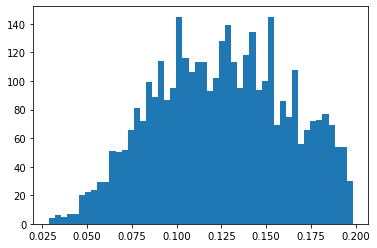

In [14]:
artifact_counts_and_depths = [(len(datum.alt_tensor()), datum.mutect2_data().tumor_depth()) for datum in data if datum.artifact_label() == 1]
afs = [count / depth for count,depth in artifact_counts_and_depths]
plt.hist(afs, bins=50)

In [15]:
#Now let's learn the spectrum of artifact allele fractions in order to combine our calibrated classifier with priors
# to get a posterior probability
# the model is alt count ~ sum_j pi_j BetaBinomial(alpha_j, beta_j, depth)
# where the coefficients pi_j sum to 1 and alpha_j, beta_j are fixed as (1,101), (6,96), (11, 91). . .(101,1)
# and we want to learn pi_j by MLE
# we enforce the normaliztion constraint by letting pi = softmax(z)


#beta binomial log likelihood
# shape parameters are 1D tensors of the same length, and the log gamma is broadcast over all pairs (alpha,beta)
def beta_binomial(n, k, alpha, beta):
    return torch.lgamma(k + alpha) + torch.lgamma(n - k + beta) + torch.lgamma(alpha + beta) \
        -torch.lgamma(n + alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta) 

class AFSpectrum:
    LEARNING_RATE = 1e-2
    EPOCHS = 5
    
    def __init__(self):
        shapes = [(n + 1, 101 - n) for n in range(0, 100, 5)]
        self.a = torch.FloatTensor([shape[0] for shape in shapes])
        self.b = torch.FloatTensor([shape[1] for shape in shapes])
        self.z = nn.Parameter(torch.ones(len(shapes)))
        
    # k "successes" out of n "trials"
    def log_likelihood(self, k, n):
        log_pi = nn.functional.log_softmax(self.z, dim=0)
        log_likelihoods = beta_binomial(n,k,self.a,self.b)
        return torch.logsumexp(log_pi + log_likelihoods, dim=0)
        
    # k_n_tuples is an iterable of tuples (k,n) as above
    def learn(self, k_n_tuples):
        # note -- a, b are constants, not learned
        optimizer = torch.optim.Adam([self.z], lr=AFSpectrum.LEARNING_RATE)
        for epoch in range(AFSpectrum.EPOCHS):
            for (k,n) in k_n_tuples:
                optimizer.zero_grad()
                nll = -self.log_likelihood(k,n)
                nll.backward()
                optimizer.step()
                
    # plot the mixture of beta densities
    def plot_spectrum(self):
        f = torch.range(0.01,0.99,0.01)
        log_pi = nn.functional.log_softmax(self.z, dim=0)
        
        shapes = [(alpha, beta) for (alpha,beta) in zip(self.a.numpy(), self.b.numpy())]
        betas = [torch.distributions.beta.Beta(torch.FloatTensor([alpha]), torch.FloatTensor([beta])) for (alpha, beta) in shapes]
        
        # list of tensors - the list is over the mixture components, the tensors are over AF values f
        unweighted_log_densities = torch.stack([beta.log_prob(f) for beta in betas], dim=0)
        # unsqueeze to make log_pi a column vector (2D tensor) for broadcasting
        weighted_log_densities = torch.unsqueeze(log_pi,1) + unweighted_log_densities
        log_densities = torch.logsumexp(weighted_log_densities, dim=0)
        return plt.plot(f.detach().numpy(), torch.exp(log_densities).detach().numpy())
        
        

<ipython-input-15-0c2e5ee42960>:44: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  f = torch.range(0.01,0.99,0.01)


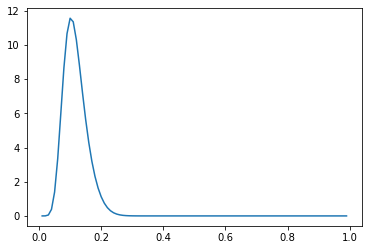

In [16]:
artifact_af_spectrum = AFSpectrum()
artifact_af_spectrum.learn(artifact_counts_and_depths)
artifact_af_spectrum.plot_spectrum()

In [17]:
class LinearStack(nn.Module):
    #layer_sizes starts from the input and ends with the output
    #optional batch normalization
    def __init__(self, layer_sizes, batch_normalize=False, batch_normalize_input=False):
        
        super(LinearStack, self).__init__()
        
        self.layers = nn.ModuleList()
        for k in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[k], layer_sizes[k+1]))
            
        self.bn = nn.ModuleList()
        
        self.batch_normalize_input = False
        if batch_normalize_input:
            self.batch_normalize_input = True
            self.bn_input = nn.BatchNorm1d(num_features=layer_sizes[0])
        
        if batch_normalize:  
            #batch normalize after every linear transformation
            for size in layer_sizes[1:]:
                self.bn.append(nn.BatchNorm1d(num_features=size))
            
    def forward(self, x):
        if self.batch_normalize_input:
            x = self.bn_input(x)

        # Feedforward -- note that last layer has no non-linearity
        for n, layer in enumerate(self.layers):
            x = layer(x)
            if self.bn:
                x = self.bn[n](x)
            if n < len(self.layers) - 1:
                x = nn.functional.relu(x)

        return x

In [18]:
# Read sets have different sizes so we can't form a batch by naively stacking tensors.  We need a custom collate 
# function for our data loader, which our model must understand.

# input batch is a list of Datum objects

class Batch:
    def __init__(self, ref, alt, ref_counts, alt_counts, info, metadata, mutect2_data, labels):
        self._ref = ref
        self._alt = alt
        self._ref_counts = ref_counts
        self._alt_counts = alt_counts
        self._info = info
        self._metadata = metadata
        self._mutect2_data = mutect2_data
        self._labels = labels
        self._size = len(labels)
        
    def size(self):
        return self._size
        
    def ref(self):
        return self._ref
    
    def alt(self):
        return self._alt
    
    def ref_counts(self):
        return self._ref_counts
    
    def alt_counts(self):
        return self._alt_counts
    
    def info(self):
        return self._info
    
    def metadata(self):
        return self._metadata
    
    def mutect2_data(self):
        return self._mutect2_data
    
    def labels(self):
        return self._labels
    
# collated batch contains:
# 2D tensors of ALL ref (alt) reads, not separated by set.
# number of reads in ref (alt) read sets, in same order as read tensors
# info: 2D tensor of info fields, one row per variant
# labels: 1D tensor of 0 if non-artifact, 1 if artifact
# lists of original mutect2_data and metadata
# Example: if we have two input data, one with alt reads [[0,1,2], [3,4,5] and the other with 
# alt reads [[6,7,8], [9,10,11], [12,13,14] then the output alt reads tensor is
# [[0,1,2], [3,4,5], [6,7,8], [9,10,11], [12,13,14]] and the output counts are [2,3]
# inside the model, the counts will be used to separate the reads into sets
def collate_read_sets(batch):
    ref_counts = torch.IntTensor([len(item.ref_tensor()) for item in batch])
    alt_counts = torch.IntTensor([len(item.alt_tensor()) for item in batch])
    ref = torch.cat([item.ref_tensor() for item in batch], dim=0)
    alt = torch.cat([item.alt_tensor() for item in batch], dim=0)
    info = torch.stack([item.info_tensor() for item in batch], dim=0)
    labels = torch.FloatTensor([item.artifact_label() for item in batch])
    metadata = [item.metadata() for item in batch]
    mutect2_data = [item.mutect2_data() for item in batch]
    return Batch(ref, alt, ref_counts, alt_counts, info, metadata, mutect2_data, labels)

In [81]:
# truncate for temperature
MAX_ALT = 10

class ReadSetClassifier(nn.Module):
    #embedding layer sizes include input, aggregation hidden layer sizes do not include its input which is 
    # the embedding output, nor its output which is a binary classification
    def __init__(self, embedding_layer_sizes, info_embedding_layer_sizes, aggregation_hidden_layer_sizes):
        super(ReadSetClassifier, self).__init__()
        
        # phi is the universal read embedding function
        self.phi = LinearStack(embedding_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        self.embedding_dimension = embedding_layer_sizes[-1] #this is the embedding dimension of one read
        
        #omega is the universal embedding of info field variant-level data
        self.omega = LinearStack(info_embedding_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        self.info_embedding_dimension = info_embedding_layer_sizes[-1]
        
        # rho is the universal aggregation function
        # the *2 is for the use of both ref and alt reads
        # the [1] is the final binary classification in logit space
        self.rho = LinearStack([2*self.embedding_dimension + self.info_embedding_dimension] + aggregation_hidden_layer_sizes + [1], batch_normalize=False, batch_normalize_input=False)
        
        # temperature scaling logit output for calibrating on validation set
        self.temperature = None
        
    # see the custom collate_fn for information on the batched input
    def forward(self, batch):
    
        # broadcast the embedding to each read
        num_sets = batch.size()
        
        phi_ref = torch.sigmoid(self.phi(batch.ref()))
        phi_alt = torch.sigmoid(self.phi(batch.alt()))
        omega_info = torch.sigmoid(self.omega(batch.info()))
                        
        ref_end = torch.cumsum(batch.ref_counts(), dim=0)
        ref_slices = [slice(0 if n == 0 else ref_end[n-1],ref_end[n]) for n in range(num_sets)]
        alt_end = torch.cumsum(batch.alt_counts(), dim=0)
        alt_slices = [slice(0 if n == 0 else alt_end[n-1],alt_end[n]) for n in range(num_sets)]
               
        # note that after taking means, tensors are now num_sets x embedding dimension
        ref_means = torch.cat([torch.mean(phi_ref[slice], dim=0, keepdim=True) for slice in ref_slices], dim=0)
        alt_means = torch.cat([torch.mean(phi_alt[slice], dim=0, keepdim=True) for slice in alt_slices], dim=0)

        #stack the ref and alt means and info side-by-side so that each row of the resulting
        # 2D tensor is (mean ref 1, . . . mean ref D, mean alt 1, . . . mean alt D, ref count)
        stacked_embeddings = torch.cat((ref_means, alt_means, omega_info), dim=1)
                
        # broadcast the aggregation over the batch
        logits = self.rho(stacked_embeddings)
        
        # scale the logits to express greater certainty ~sqrt(N) with increasing alt count.  We might get rid of this.
        output = logits  * torch.sqrt(torch.unsqueeze(batch.alt_counts(),1).float())
        
        # note that no non-linearity is applied here because nn.BCEWithLogitsLoss() includes
        # the sigmoid.  Thus when classifying we will have to apply the sigmoid explicitly
        
        if self.temperature is not None:
            truncated_counts = torch.LongTensor([min(c,MAX_ALT) for c in batch.alt_counts()])
            return torch.squeeze(output) / torch.index_select(self.temperature, 0, truncated_counts)
        else:
            return torch.squeeze(output)
        
    def set_temperature(self, valid_loader):
        
        self.temperature = torch.ones(MAX_ALT + 1)
        
        
        # First: collect all the logits and labels for the validation set
        logits_list, labels_list, alt_counts_list = [], [], []
        with torch.no_grad():
            for batch in valid_loader:
                logits_list.append(self.forward(batch))
                labels_list.append(batch.labels())
                alt_counts_list.append(batch.alt_counts())
            logits = torch.cat(logits_list)
            labels = torch.cat(labels_list)
            alt_counts = torch.cat(alt_counts_list)

        self.temperature.requires_grad = True
        nll_criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            truncated_counts = torch.LongTensor([min(c,MAX_ALT) for c in alt_counts])
            temperatures = torch.index_select(self.temperature, 0, truncated_counts)
            loss = nll_criterion(logits / temperatures, labels)
            loss.backward()
            return loss
        optimizer.step(eval)
        self.temperature.requires_grad = False
        
    def uncalibrate(self):
        self.temperature = None


In [82]:
# modify the output of a wrapped read set classifier (may be temperature-scaled) to account for
# 1. overall prior probability of artifact vs variant
# 2. artifact AF spectrum
# 3. variant AF spectrum
class PriorAdjustedReadSetClassifier(nn.Module):
    """
    A thin decorator, which wraps the above model with temperature scaling
    NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model, artifact_proportion, artifact_spectrum, variant_spectrum):
        super(PriorAdjustedReadSetClassifier, self).__init__()
        self.model = model
        self.log_artifact_proportion = torch.log(torch.FloatTensor([artifact_proportion]))
        self.log_variant_proportion = torch.log(torch.FloatTensor([1 - artifact_proportion]))
        self.artifact_spectrum = artifact_spectrum
        self.variant_spectrum = variant_spectrum
        

    def forward(self, batch):
        # these logits are from a model trained on a balanced data set i.e. they are (implicitly)
        # the posterior probability of an artifact when the priors are flat
        # that is, they represent log likelihood ratio log(P(data|artifact)/P(data|non-artifact))
        artifact_to_variant_log_likelihood_ratios = self.model(batch)
            
        alt_counts = batch.alt_counts().numpy()
        depths = [datum.tumor_depth() for datum in batch.mutect2_data()]
        
        # these are relative log priors of artifacts and variants to have k alt reads out of n total
        artifact_log_priors = torch.FloatTensor([self.log_artifact_proportion + self.artifact_spectrum.log_likelihood(k, n).item() for (k,n) in zip(alt_counts, depths)])
        variant_log_priors = torch.FloatTensor([self.log_variant_proportion + self.variant_spectrum.log_likelihood(k, n).item() for (k,n) in zip(alt_counts, depths)])
        artifact_to_variant_log_prior_ratios = artifact_log_priors - variant_log_priors
        
        # the sum of the log prior ratio and the log likelihood ratio is the log posterior ratio
        # that is, it is the output we want, in logit form
        return artifact_to_variant_log_prior_ratios + artifact_to_variant_log_likelihood_ratios

In [83]:
def round_alt_count_for_binning(alt_count):
    if alt_count < 15:
        return alt_count
    else:
        return alt_count - alt_count % 5

In [84]:
def plot_learning_curves(train_losses, valid_losses):
    fig = plt.figure()
    learning_curve = fig.gca()
    epochs = range(1, len(train_losses) + 1)
    learning_curve.plot(epochs, train_losses, label = "training")
    learning_curve.plot(epochs, valid_losses, label = "validation")
    learning_curve.set_title("Learning curves")
    learning_curve.set_xlabel("epoch")
    learning_curve.set_ylabel("loss")
    learning_curve.legend() 
    return fig, learning_curve

In [85]:
# confusion_matrices is dict of alt count to 2x2 [[,],[,]] confusion matrices where 0/1 is non-artifact/artifact
# and 1st index is truth, 2nd index is prediction
def plot_sensitivities(confusion_matrices, name):
    counts = []
    variant_sensitivities = []
    artifact_sensitivities = []
    for alt_count_bin in sorted(confusion_matrices.keys()):
        matrix = confusion_matrices[alt_count_bin]
        if (matrix[0][0] + matrix[0][1]) == 0 or (matrix[1][0] + matrix[1][1]) == 0:
            continue

        counts.append(alt_count_bin)
        variant_sensitivities.append(matrix[0][0] / (matrix[0][0] + matrix[0][1]))
        artifact_sensitivities.append(matrix[1][1] / (matrix[1][0] + matrix[1][1]))

    fig = plt.figure()
    accuracy_curve = fig.gca()
    accuracy_curve
    accuracy_curve.clear()
    accuracy_curve.plot(counts, variant_sensitivities, label = "variant sensitivity")
    accuracy_curve.plot(counts, artifact_sensitivities, label = "artifact sensitivity")
    accuracy_curve.set_title("Variant and artifact sensitivity by alt count for " + name)
    accuracy_curve.set_xlabel("alt count")
    accuracy_curve.set_ylabel("sensitivity")
    accuracy_curve.legend()
    return fig, accuracy_curve

In [86]:
def plot_scores(artifact_scores, non_artifact_scores, name):
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for n, count in enumerate([2, 3, 5, 7, 9, 12, 16, 20, 25]):
        row = int(n/3)
        col = n % 3
        ax[row, col].hist(non_artifact_scores[count], bins=50, alpha = 0.5, label = 'non-artifacts')
        ax[row, col].hist(artifact_scores[count], bins=50, alpha = 0.5, label = 'artifacts')
        ax[row, col].set_title("Alt count " + str(count) + " for " + name)
        ax[row, col].set_xlabel("score")
        ax[row, col].legend()
    return fig, ax

In [87]:
class ValidationStats:
    def __init__(self):
        self.confusion_by_count = defaultdict(lambda: [[0,0],[0,0]])
        self.confusion = [[0,0],[0,0]]
        
        self.artifact_scores_by_count = defaultdict(list)
        self.non_artifact_scores_by_count = defaultdict(list)
        
        self.missed_artifacts_by_count = defaultdict(list)
        self.missed_variants_by_count = defaultdict(list)
        
    # prediction and truth are 0 if not artifact, 1 if artifact
    def add(self, alt_count, truth, prediction, score, filters, position):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        self.confusion_by_count[alt_count_bin][truth][prediction] += 1
        self.confusion[truth][prediction] += 1
        (self.artifact_scores_by_count if truth == 1 else self.non_artifact_scores_by_count)[alt_count_bin].append(score)
        
        if truth == 1 and prediction == 0:
            self.missed_artifacts_by_count[alt_count_bin].append((score, position, filters))
        elif truth == 0 and prediction == 1:
            self.missed_variants_by_count[alt_count_bin].append((score, position, filters))
        
    def confusion_matrices(self):
        return self.confusion_by_count
    
    def confusion(self):
        return self.confusion
    
    def sensitivity(self):
        return self.confusion[0][0]/(self.confusion[0][0] + self.confusion[0][1])
    
    def precision(self):
        return self.confusion[0][0]/(self.confusion[0][0] + self.confusion[1][0])
    
    def artifact_scores(self):
        return self.artifact_scores_by_count
    
    def non_artifact_scores(self):
        return self.non_artifact_scores_by_count
    
    def worst_missed_variants(self, alt_count):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        #sort from highest score to lowest
        return sorted(self.missed_variants_by_count[alt_count_bin], key=lambda x: -x[0])
    
    def worst_missed_artifacts(self, alt_count):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        #sort from highest score to lowest
        return sorted(self.missed_artifacts_by_count[alt_count_bin], key=lambda x: x[0])
        
       
    

In [88]:
#note the m2 filters to keep here are different from those used to generate the training data
# above, they were filters that are not artifacts, such as germline, contamination, and weak evidence
# here, they are artifact filters that we intend to use in M3, such as the normal artifact filter

#threshold is threshold of logit prediction for considering variant an artifact -- this is a quick way to
# explore translating likelihoods from balanced training to posteriors, which we will alter do in a principled way
def get_validation_stats(model, loader, m2_filters_to_keep = {}, threshold=0.0):
    stats = ValidationStats()

    model.train(False)
    for batch in loader:
        labels = batch.labels()
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        alt_counts = batch.alt_counts()
        predictions = model(batch)
        positions = [meta.locus() for meta in batch.metadata()]
        for n in range(batch.size()):  
            truth = 1 if labels[n].item() > 0.5 else 0
            pred = 1 if (predictions[n] > threshold or filters[n].intersection(m2_filters_to_keep)) else 0   
            stats.add(alt_counts[n].item(), truth, pred, predictions[n].item(), filters[n], positions[n])
            
    return stats

In [89]:
# optimize F1 score

def F_score(tp, fp, total_true):
    fn = total_true - tp
    return tp / (tp + (fp + fn)/2)
   
def calculate_true_prob_threshold(model, loader, m2_filters_to_keep = {}):
    model.train(False)
    true_variant_probs = []
    
    for batch in loader:
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        logits = model(batch)
        artifact_probs = torch.exp(logits)/(torch.exp(logits) + 1)
        
        for n in range(batch.size()):  
            if not filters[n].intersection(m2_filters_to_keep):
                logit = logits[n].item()
                true_variant_probs.append( 1 - artifact_probs[n].item())
        
    true_variant_probs.sort()
    total_variants = sum(true_variant_probs)
    
    # we are going to start by accepting everything -- the threshold is just below the smallest probability
    threshold = 0 # must be greater than or equal to this threshold for true variant probability
    tp = total_variants
    fp = len(true_variant_probs) - total_variants
    best_F = F_score(tp, fp, total_variants)
    
    for prob in true_variant_probs: # we successively reject each probability and increase the threshold
        tp = tp - prob
        fp = fp - (1 - prob)
        F = F_score(tp, fp, total_variants)
        
        print ((prob, tp, fp, F))
        if F > best_F:
            best_F = F
            threshold = prob
    
    return threshold

In [90]:
# get the same stats for Mutect2 using the M2 filters and truth labels
def get_m2_validation_stats(loader):
    stats = ValidationStats()

    for batch in loader:
        labels = batch.labels()
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        alt_counts = batch.alt_counts()
        positions = [meta.locus() for meta in batch.metadata()]
        for n in range(batch.size()):  
            truth = 1 if labels[n].item() > 0.5 else 0
            pred = 0 if 'PASS' in filters[n] else 1  
            score = 1 if pred == 1 else -1
            stats.add(alt_counts[n].item(), truth, pred, score, filters[n], positions[n])
            
    return stats

In [91]:
# learn artifact and variant AF spectra from a validation or test loader
def learn_af_spectra(model, loader, m2_filters_to_keep = {}, threshold=0.0):
    artifact_k_n = []
    variant_k_n = []
    for batch in loader:
        depths = [datum.tumor_depth() for datum in batch.mutect2_data()]
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        alt_counts = batch.alt_counts()
        predictions = model(batch)
        for n in range(batch.size()):  
            is_artifact = predictions[n] > threshold or filters[n].intersection(m2_filters_to_keep)
            (artifact_k_n if is_artifact else variant_k_n).append((alt_counts[n].item(), depths[n]))
            
    artifact_af_spectrum = AFSpectrum()
    variant_af_spectrum = AFSpectrum()
    
    artifact_af_spectrum.learn(artifact_k_n)
    variant_af_spectrum.learn(variant_k_n)
    artifact_proportion = len(artifact_k_n)/(len(artifact_k_n) + len(variant_k_n))
                        
    return artifact_proportion, artifact_af_spectrum, variant_af_spectrum

In [92]:
BATCH_SIZE = 64

train_labels = [datum.artifact_label() for datum in train]
valid_labels = [datum.artifact_label() for datum in valid]

model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10, 10], [10]).float()
class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
samples_per_epoch = 20*int(class_counts[1]) #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact

class_weights = 1.0/class_counts

train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
    
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_read_sets, drop_last=True)
valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, collate_fn=collate_read_sets, drop_last=True)
test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, collate_fn=collate_read_sets, drop_last=True)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([NON_ARTIFACT_PER_ARTIFACT]))
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# track loss and accuracy as map from alt count bins to lists by epoch
train_losses = []
valid_losses = []
test_losses = []

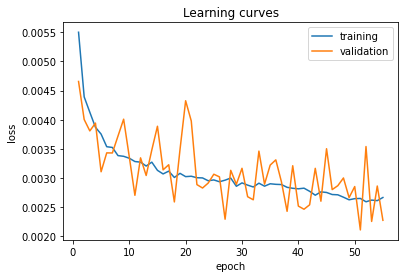

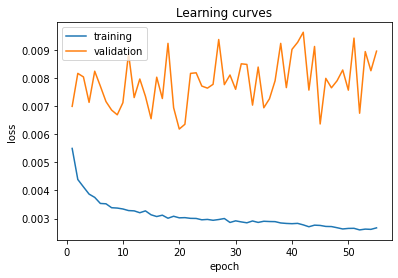

In [96]:
EPOCHS = 50
model.uncalibrate() # discard any previous calibration before training (useful in case we re-run this cell for extra epochs)
for epoch in range(0, EPOCHS):
    for (loader, losses, epoch_type) in [(train_loader, train_losses, "training"), (valid_loader, valid_losses, "validating"), (test_loader, test_losses, "testing")]:   
        is_training = epoch_type == "training"
        model.train(is_training)
        epoch_loss = 0

        for batch_number, batch in enumerate(loader):
            if batch_number % 1000 == 0:
                print("Epoch " + str(epoch) +": " + epoch_type + " batch " + str(batch_number))
                clear_output(wait=True)
            
            predictions = model(batch)              
            loss = criterion(predictions, batch.labels())
            epoch_loss += loss.item()
          
            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(epoch_loss / (len(loader)*BATCH_SIZE))
    # end of epoch
# model is trained

fig, learning_curve = plot_learning_curves(train_losses, valid_losses) 
fig2, learning_curve2 = plot_learning_curves(train_losses, test_losses) 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b8ffb65e0>)

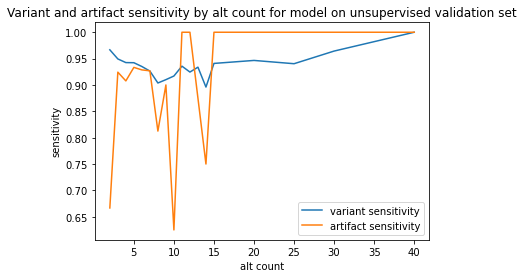

In [97]:
model.set_temperature(valid_loader)
valid_stats = get_validation_stats(model, valid_loader)      
plot_sensitivities(valid_stats.confusion_matrices(), "model on unsupervised validation set")
#plot_scores(valid_stats.artifact_scores(), valid_stats.non_artifact_scores(), "validation")

In [98]:
print(model.temperature)

tensor([1.0000, 0.9954, 0.9709, 0.8655, 0.8990, 0.9614, 1.0074, 1.0330, 1.0146,
        1.0393, 1.1131])


<ipython-input-15-0c2e5ee42960>:44: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  f = torch.range(0.01,0.99,0.01)
<ipython-input-15-0c2e5ee42960>:44: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  f = torch.range(0.01,0.99,0.01)


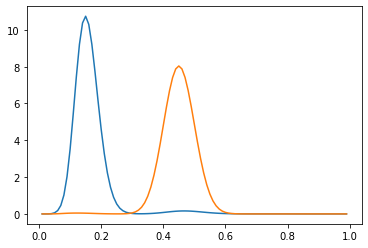

In [99]:
artifact_proportion, artifact_spectrum, variant_spectrum = learn_af_spectra(model, test_loader, m2_filters_to_keep = {'normal_artifact'}, threshold=-4.0)
posterior_model = PriorAdjustedReadSetClassifier(model, artifact_proportion, artifact_spectrum, variant_spectrum)
artifact_spectrum.plot_spectrum()
variant_spectrum.plot_spectrum()

In [100]:
threshold = calculate_true_prob_threshold(model, test_loader, {'normal_artifact'})
print(threshold)
artifact_threshold = 1 - threshold
logit_threshold = np.log(artifact_threshold/(1 - artifact_threshold))
print(logit_threshold)

(7.68899917602539e-06, 3961.925123675235, 2638.074876324765, 0.7502278371411807)
(8.046627044677734e-06, 3961.925115628608, 2637.074884371392, 0.7502988736966486)
(8.52346420288086e-06, 3961.925107105144, 2636.074892894856, 0.7503699236157944)
(1.6927719116210938e-05, 3961.925090177425, 2635.074909822575, 0.750440985400857)
(1.7762184143066406e-05, 3961.9250724152407, 2634.0749275847593, 0.7505120604891623)
(1.817941665649414e-05, 3961.925054235824, 2633.074945764176, 0.7505831489635351)
(2.104043960571289e-05, 3961.9250331953845, 2632.0749668046155, 0.7506542503647617)
(2.1159648895263672e-05, 3961.9250120357356, 2631.0749879642644, 0.7507253652160493)
(2.467632293701172e-05, 3961.9249873594126, 2630.0750126405874, 0.750796492877391)
(2.6226043701171875e-05, 3961.924961133369, 2629.075038866631, 0.7508676337252076)
(2.771615982055664e-05, 3961.924933417209, 2628.075066582791, 0.7509387877745454)
(2.855062484741211e-05, 3961.9249048665843, 2627.0750951334157, 0.7510099551534412)
(3.117

(0.04346674680709839, 3949.8978225425562, 962.1021774574438, 0.890225636135228)
(0.04372495412826538, 3949.854097588428, 961.145902411572, 0.8903161108902827)
(0.04386186599731445, 3949.8102357224307, 960.1897642775693, 0.8904065751770087)
(0.04389387369155884, 3949.766341848739, 959.2336581512609, 0.8904970526431025)
(0.04436290264129639, 3949.721978946098, 958.2780210539022, 0.8905874447530118)
(0.04436737298965454, 3949.677611573108, 957.3223884268918, 0.8906778562388341)
(0.04453998804092407, 3949.6330715850672, 956.3669284149328, 0.8907682491851302)
(0.04478800296783447, 3949.5882835820994, 955.4117164179006, 0.8908586065786324)
(0.04487967491149902, 3949.543403907188, 954.4565960928121, 0.8909489636755947)
(0.04493296146392822, 3949.498470945724, 953.501529054276, 0.8910393291359767)
(0.04510331153869629, 3949.4533676341853, 952.5466323658147, 0.8911296765491363)
(0.04518646001815796, 3949.408181174167, 951.5918188258329, 0.8912200255868009)
(0.045261263847351074, 3949.3629199103

(0.9593259654939175, 3404.3307526022872, 8.669247397712752, 0.9232177118990074)
(0.9593979567289352, 3403.3713546455583, 8.628645354441687, 0.9230826985670542)
(0.9594680443406105, 3402.4118866012177, 8.588113398782298, 0.9229476295988535)
(0.9598558209836483, 3401.452030780234, 8.547969219765946, 0.9228124187828717)
(0.9601626023650169, 3400.491868177869, 8.508131822130963, 0.9226770880383356)
(0.9602970480918884, 3399.531571129777, 8.468428870222851, 0.9225416840837013)
(0.960300587117672, 3398.5712705426595, 8.428729457340523, 0.9224062424185521)
(0.9609278589487076, 3397.6103426837108, 8.389657316289231, 0.922270593717234)
(0.9610835425555706, 3396.649259141155, 8.350740858844802, 0.9221348659239466)
(0.9611239954829216, 3395.6881351456723, 8.311864854327723, 0.921999090293974)
(0.961151722818613, 3394.7269834228537, 8.273016577146336, 0.9218632702635593)
(0.9612623192369938, 3393.7657211036167, 8.23427889638333, 0.9217273833078449)
(0.9614807590842247, 3392.8042403445324, 8.195759

(0.9991066314396448, 1912.3483230370657, 0.6516769629342889, 0.651020491419605)
(0.9991097347228788, 1911.3492133023428, 0.6507866976571677, 0.6507911389937744)
(0.999113094760105, 1910.3501002075827, 0.6498997924172727, 0.6505617073186912)
(0.9991132581490092, 1909.3509869494337, 0.6490130505662819, 0.6503321974426575)
(0.9991135782911442, 1908.3518733711426, 0.6481266288574261, 0.6501026092723129)
(0.9991137231700122, 1907.3527596479726, 0.6472403520274383, 0.6498729428273587)
(0.999113762518391, 1906.3536458854542, 0.6463541145458294, 0.6496431981037459)
(0.9991142242215574, 1905.3545316612326, 0.6454683387673867, 0.6494133749175005)
(0.9991142479120754, 1904.3554174133205, 0.6445825866794621, 0.6491834733778173)
(0.9991152802831493, 1903.3563021330374, 0.6436978669626114, 0.6489534931007124)
(0.9991161035140976, 1902.3571860295233, 0.6428139704767091, 0.648723434117229)
(0.9991165808751248, 1901.3580694486482, 0.6419305513518339, 0.6484932965050663)
(0.9991175686009228, 1900.358951

(0.9999367502969108, 214.9922143083204, 0.007785691679600859, 0.10294281441338707)
(0.9999375433835667, 213.99227676493683, 0.007723235063167522, 0.10248856003557115)
(0.9999381254674518, 212.99233863946938, 0.007661360530619277, 0.10203408776811773)
(0.9999384446782642, 211.99240019479112, 0.007599805208883481, 0.10157939758037876)
(0.9999385482660728, 210.99246164652504, 0.007538353474956239, 0.10112448941903077)
(0.9999387282514363, 209.9925229182736, 0.007477081726392498, 0.10066936309070594)
(0.999938766748528, 208.99258415152508, 0.0074158484749204945, 0.1002140185063295)
(0.9999388784708572, 207.99264527305422, 0.0073547269457776565, 0.0997584554737592)
(0.9999389448785223, 206.9927063281757, 0.007293671824299963, 0.09930267385753681)
(0.9999395200138679, 205.99276680816183, 0.007233191838167841, 0.09884667325621409)
(0.9999395674058178, 204.99282724075601, 0.007172759243985638, 0.09839045376543264)
(0.9999398831932922, 203.99288735756272, 0.007112642437277827, 0.097934015098711

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b5070f4f0>)

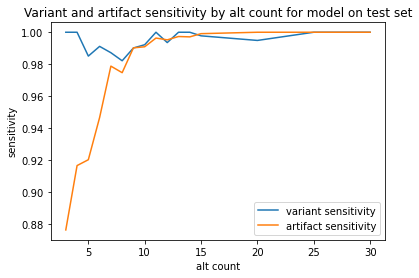

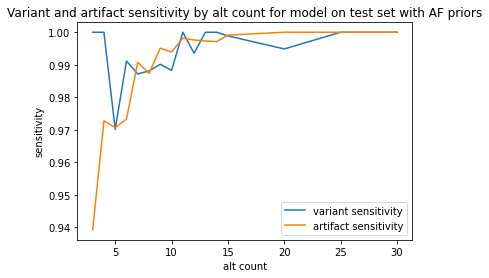

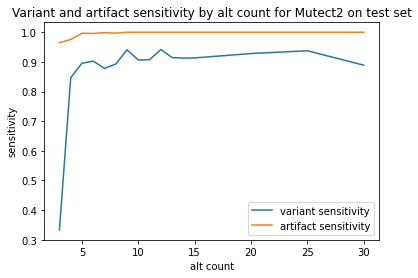

In [101]:
test_stats = get_validation_stats(model, test_loader, {'normal_artifact'}, logit_threshold)
plot_sensitivities(test_stats.confusion_matrices(), "model on test set")
posterior_test_stats = get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, -1)
plot_sensitivities(posterior_test_stats.confusion_matrices(), "model on test set with AF priors")
m2_stats = get_m2_validation_stats(test_loader)
plot_sensitivities(m2_stats.confusion_matrices(), "Mutect2 on test set")
#plot_scores(test_stats.artifact_scores(), test_stats.non_artifact_scores(), "test")

In [102]:
print((posterior_test_stats.sensitivity(), posterior_test_stats.precision()))
print((test_stats.sensitivity(), test_stats.precision()))
print((m2_stats.sensitivity(), m2_stats.precision()))

(0.9950632520826905, 0.9238040676024062)
(0.9950632520826905, 0.83161423414131)
(0.9129898179574205, 0.9663618549967342)


In [36]:
print((posterior_test_stats.sensitivity(), posterior_test_stats.precision()))
print((test_stats.sensitivity(), test_stats.precision()))
print((m2_stats.sensitivity(), m2_stats.precision()))

(0.9947547053378587, 0.9443468072642062)
(0.9956803455723542, 0.8436601307189543)
(0.9129898179574205, 0.9663618549967342)


In [37]:
test_stats.worst_missed_artifacts(5)

[(-6.262435436248779, 'X:41190284', {'panel_of_normals'}),
 (-6.065316200256348, '6:451007', {'clustered_events', 'haplotype'}),
 (-6.025035381317139,
  '6:451010',
  {'base_qual', 'clustered_events', 'haplotype'}),
 (-5.475095272064209, '5:79035488', {'clustered_events', 'slippage'}),
 (-5.323553562164307, '3:154213412', {'haplotype', 'panel_of_normals'}),
 (-5.266298770904541, '12:82300198', {'haplotype', 'panel_of_normals'}),
 (-5.2299981117248535, '13:61787604', {'PASS'}),
 (-5.184303283691406, '16:81729522', {'panel_of_normals', 'slippage'}),
 (-5.142451286315918, '2:171894122', {'haplotype', 'panel_of_normals'}),
 (-5.046854496002197, '11:66048452', {'haplotype', 'panel_of_normals'}),
 (-4.966700553894043, '3:154213414', {'haplotype', 'panel_of_normals'}),
 (-4.92069149017334, '4:45495101', {'PASS'}),
 (-4.916968822479248, '18:57852948', {'panel_of_normals'}),
 (-4.8742876052856445,
  '8:10853035',
  {'clustered_events', 'haplotype', 'panel_of_normals'}),
 (-4.724488258361816, '2